In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [62]:
sns.set(style="darkgrid", font_scale=1.5)

In [63]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

After importing the libraries, we can now get the data we need:

In [64]:
df = pd.read_csv("../data/MorningTest2.csv")[['price']]
df.shape

(14700, 1)

In [65]:
df.head()

,price
0,1156.360000
1,1155.770000
2,1155.754637
3,1155.606552
4,1155.682215


As you can see, the data includes almost 1 million rows. I just need a part of which is the "open" prince of "litecoin".

In [66]:
df.shape

(14700, 1)

We now have the historical data of litecoin from April,2013 to November,2018. Let's take a look at how it changed through time.

Text(0.5, 1.0, 'Price of ETHER')

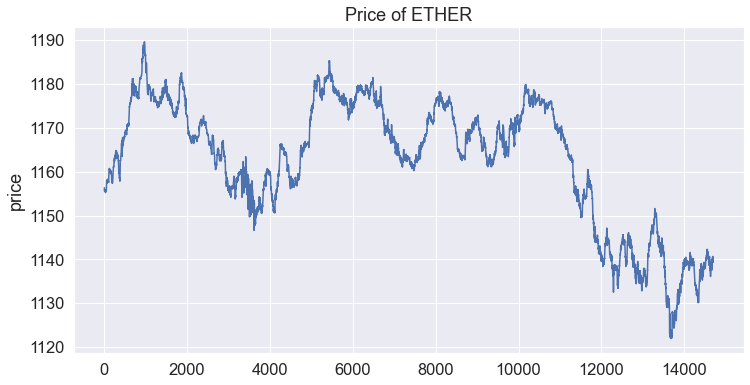

In [68]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="price", data=df).set_title("Price of ETHER")

In [69]:
#df.resample('.01D').mean().plot(figsize=(12,6))
#plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

# Model

Long short-term memory (LSTM) is a type of recurrent neural network (RNN) and powerful to model sequence data because it maintains an internal state to keep track of the data it has already seen. Common applications of LSTMs include time series analysis and natural language processing.

LSTM requires the input to be a 3D tensor with shape (batch_size, timesteps, input_dim).

Batch_size: 
Timesteps:
input_dim:

I will build a model that predicts the value of litecoin at time t using the past 90 values (from t-90 to t-1). Therefore the the number of timesteps is 90. I only use "open" price to make the prediction so the input_dim is 1. The target variable is "open" price of litecoin which can be effected by many other factors. For example, the value of another crptocurrency may have an effect on litecoin. If we also use a second variable to make the prediction, than the input_dim will be 2.

## Data Preprocessing

I will re-organize the data in a way that a sequence of the values in previous 90 days is used to predict the value at time t. It is also better to normalize the values due to excessive computations done in a neural network.

In [70]:
data = df.iloc[:, 0]

In [71]:
hist = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [72]:
print(len(hist[0]))
print(len(hist))
print(len(target))

90
14610
14610


In [73]:
print(hist[0][length-1])
print(data[length-1])

1158.1014480000001
1158.1014480000001


The last timestep of the first element is same as the 90th timestep of the original data which is what we planned to do.

The second element of hist should be just one timestep shifted version of first element. Therefore, the last timestep in the second element should be equal to the first item of the target variable which is the 91st timestep in the original data.

Let's double check to confirm:

In [74]:
print(hist[1][length-1])
print(data[length])
print(target[0])

1158.1014480000001
1158.003163
1158.003163


In [75]:
print(type(hist), type(target))

<class 'list'> <class 'list'>


In [76]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [77]:
print(type(hist), type(target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [78]:
hist.shape

(14610, 90)

In [79]:
target.shape

(14610,)

In [80]:
target = target.reshape(-1,1)
target.shape

(14610, 1)

In [81]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [82]:
#Reshape the input
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(14610, 90, 1)


## Training and test sets

Our dataset includes 1951 samples (days). A sample of input consists of the value of litecoin for 90 consecutive days and target variable is the value of litecoin on the following day after the 90-day period.

I will split the dataset in a way that 1900 samples are used for training and then the model will be used to predict the trend in the following 51 days


In [83]:
X_train = hist_scaled[:36000,:,:]
X_test = hist_scaled[36000:,:,:]

y_train = target_scaled[:36000,:]
y_test = target_scaled[36000:,:]

## Building the neural network

In [84]:
import tensorflow as tf

from tensorflow.keras import layers, optimizers

In [85]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(length,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 90, 32)            4352      
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


We have created a model with 3 LSTM layers and 1 dense layer. It is time to compile and train the model.

In [86]:
#lr_schedule = optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=50,
#    decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate=.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [87]:
history = model.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
457/457 [==============================] - 47s 84ms/step - loss: 0.0269
Epoch 2/6
457/457 [==============================] - 39s 85ms/step - loss: 0.0023
Epoch 3/6
457/457 [==============================] - 40s 88ms/step - loss: 0.0019
Epoch 4/6
457/457 [==============================] - 41s 89ms/step - loss: 0.0016
Epoch 5/6
457/457 [==============================] - 41s 90ms/step - loss: 0.0011
Epoch 6/6
457/457 [==============================] - 43s 95ms/step - loss: 7.4080e-04


It seems like the model is converged in 30 epochs so there is no need to do additional epochs. The loss is less than 0.002 which I think is pretty good. 

Let's visualize how loss changes as number of epochs increases.

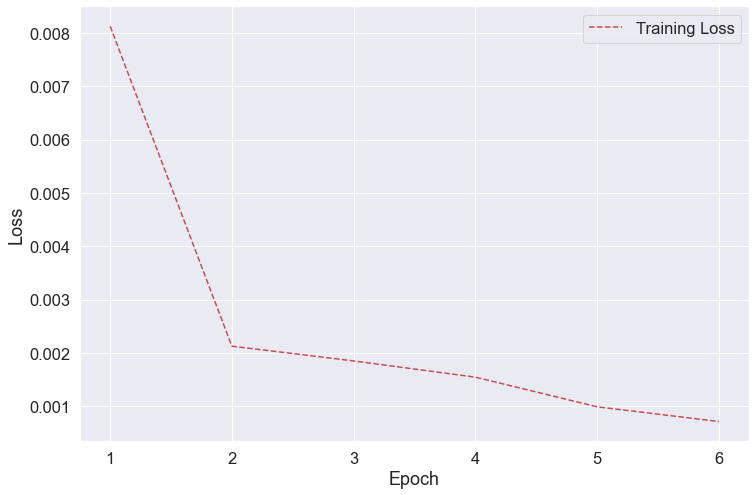

In [88]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

It seems like the model has converged after 15 epochs. After that, the loss is bouncing up and down around 0.0018.

Now it is time to make predictions.

In [89]:
# X_test.shape

(0, 90, 1)

In [90]:
# pred = model.predict(X_test)
# pred_list = []


# for i in range(10):
#     print("Perdicting ", i, "step into future")
#     pred_list.append(model.predict(X_test)[0])
#     X_test = np.append(X_test[:,1:,:][[pred_list[i]]],axis=1)

ValueError: Expect x to be a non-empty array or dataset.

In [255]:
# pred_transformed = sc.inverse_transform(pred)
# y_test_transformed = sc.inverse_transform(y_test)

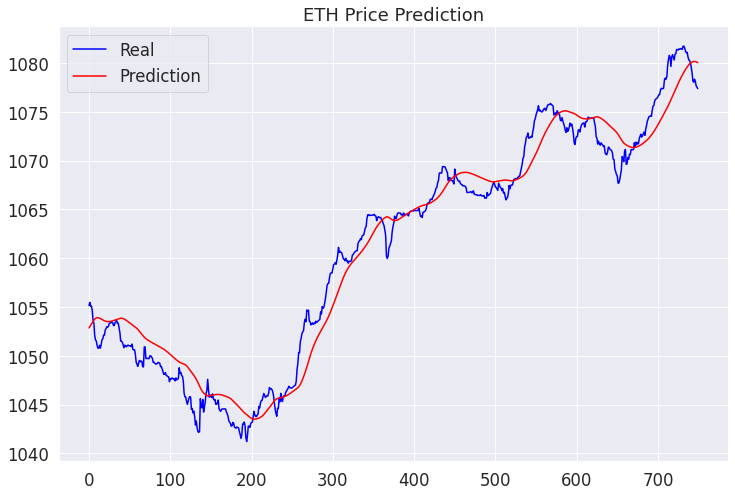

In [256]:
# plt.figure(figsize=(12,8))
# plt.plot(y_test_transformed, color='blue', label='Real')
# plt.plot(pred_transformed, color='red', label='Prediction')
# plt.title('ETH Price Prediction')
# plt.legend()
# plt.show()

In [257]:
# good = 0
# bad = 0
# i = 1
# while(i < len(y_test_transformed)-10):
#     if (y_test_transformed[i] < y_test_transformed[i+10]) and (pred_transformed[i] < pred_transformed[i+10]):
#         # we're going up
#         good = good + 1
#     elif (y_test_transformed[i] > y_test_transformed[i+10]) and (pred_transformed[i] > pred_transformed[i+10]):
#         good = good + 1
#     else:
#         bad = bad +1
#     i = i + 10
# print(good)
# print(bad)
# print(good/(good+bad))


46
28
0.6216216216216216


In [91]:
# from tensorflow.python.keras.models import Model, load_model
# model.save("ltsm_mt")

INFO:tensorflow:Assets written to: ltsm_mt\assets
INFO:tensorflow:Assets written to: ltsm_mt\assets


In [93]:
past_pred = []
for j in range(5):

    df = pd.read_csv("../data/MorningTest3.csv")[['price']]
    predicted_df = pd.DataFrame({'price': past_pred})
    df = df.append(predicted_df, ignore_index=True)
    df = df.iloc[len(past_pred):]
    data = df.iloc[:, 0]

    hist = []
    target = []
    length = 90


    for i in range(len(data)-length):
        x = data[i:i+length]
        y = data[i+length]
        hist.append(x)
        target.append(y)


    #convert list to array
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    sc = MinMaxScaler()
    hist_scaled = sc.fit_transform(hist)
    target_scaled = sc.fit_transform(target)

    #Reshape the input
    hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
    #print(hist_scaled)
    pred = model.predict(hist_scaled)
    #print(pred)
    #prepend_array = np.full((length, 1), 0)
    #pred = np.concatenate((prepend_array,pred))

    pred_transformed = sc.inverse_transform(pred)
    #y_test_transformed = sc.inverse_transform(target_scaled)

    #plt.figure(figsize=(24,8))
    #plt.plot(y_test_transformed, color='blue', label='Real')
    #plt.plot(pred_transformed, color='red', label='Prediction')
    #plt.title('ETH Price Prediction')
    #plt.legend()
    #plt.show()

    #print(len(pred_transformed))
    
    past_pred.append(pred_transformed[-1])
    print("Next predicted:",pred_transformed[-1], j)
    #print(len(y_test_transformed))

Next predicted: [1252.5464] 0
Next predicted: [1252.5625] 1
Next predicted: [1252.5746] 2
Next predicted: [1252.5817] 3
Next predicted: [1252.584] 4
